# Registration with Gromov-Wasserstein transport plan

## Description

This registration technique uses the Gromov-Wasserstein transport plan instead of the traditional optimal transport plan to perform EM-based polynomial regression.

## Imports and magics

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import affine_transform
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from ot.utils import dist 
from ot.gromov import gromov_wasserstein

from otimage import imagerep, io
from otimage.utils import plot_maxproj_units

## Implement GW registration

In [3]:
def _normalized_dist_mtx(pts_1, pts_2, metric):
    """Return distance matrix normalized by median."""
    
    mtx_nn = dist(pts_1, pts_2, metric=metric)
    return mtx_nn / np.median(mtx_nn)

def _compute_gw(pts_1, pts_2, wts_1, wts_2):
    """Normalize weights and compute OT matrix."""
    
    # Normalize weights
    p_1 = wts_1 / np.sum(wts_1)
    p_2 = wts_2 / np.sum(wts_2)

    # Normalized distance matrices
    c_1 = _normalized_dist_mtx(pts_1, pts_1, metric='sqeuclidean')
    c_2 = _normalized_dist_mtx(pts_2, pts_2, metric='sqeuclidean')
    
    # Compute transport plan
    return gromov_wasserstein(c_1, c_2, p_1, p_2, 'square_loss', log=True)

def _gw_reg(pts_1, pts_2, p_mtx):
    """Compute weighted polynomial regression using GW plan"""
    
    # Get pairs of points with values above threshold, and corresponding weights from P matrix
    idx_1, idx_2 = np.nonzero(p_mtx)
    x = pts_1[idx_1]
    y = pts_2[idx_2]
    smp_wt = p_mtx[idx_1, idx_2]

    # Use sklearn to minimize cost function
    model = Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=True)),
        ('linear', LinearRegression(fit_intercept=False))
    ])
    model.fit(x, y, linear__sample_weight=smp_wt)
   
    return model

def gw_reg_poly(mp_1, mp_2, n_iter):
    """EM-based GW registration method with polynomial model."""
    
    pts = [None] * (n_iter + 1)
    model = [None] * n_iter
    p_mtx = [None] * n_iter
    gw_log = [None] * n_iter
    
    pts[0] = mp_1.pts
    
    for i in range(n_iter):
        
        # E-step: Compute OT between current points and target points
        p_mtx[i], gw_log[i] = _compute_gw(pts[i], mp_2.pts, mp_1.wts, mp_2.wts)
        
        # M-step: Compute new mapping using transport plan
        model[i] =  _gw_reg(mp_1.pts, mp_2.pts, p_mtx[i])
       
        # Update points 
        pts[i + 1] = model[i].predict(mp_1.pts)
       
    debug = {
        'model': model,
        'pf_pts': pts,
        'p_mtx': p_mtx,
        'gw_log': gw_log,
    }
   
    return model[-1], debug

## Load data

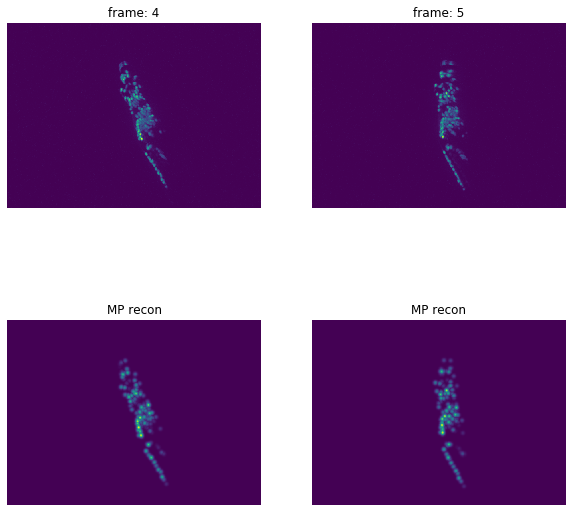

In [4]:
# Frame index
t1 = 4
t2 = 5

# Load two successive frames from dataset
img_path = '/home/mn2822/Desktop/WormOT/data/zimmer/raw/mCherry_v00065-00115.hdf5'
with io.ZimmerReader(img_path) as reader:
    units = reader.units
    img_1 = reader.get_frame(t1)
    img_2 = reader.get_frame(t2)
    
# Load MP components
mp_path = '/home/mn2822/Desktop/WormOT/data/zimmer/mp_components/mp_0000_0050.h5'
with io.MPReader(mp_path) as reader:
    mp_1 = reader.get_frame(t1)
    mp_2 = reader.get_frame(t2)

# Reconstruct images from MPs
rec_1 = imagerep.reconstruct_mp_image(mp_1, units)
rec_2 = imagerep.reconstruct_mp_image(mp_2, units)
  
plt.figure(figsize=(10, 10))

plt.subplot(221)
plot_maxproj_units(img_1, units)
plt.title(f'frame: {t1}')
plt.axis('off')

plt.subplot(222)
plot_maxproj_units(img_2, units)
plt.title(f'frame: {t2}')
plt.axis('off');

plt.subplot(223)
plot_maxproj_units(rec_1, units)
plt.title('MP recon')
plt.axis('off')

plt.subplot(224)
plot_maxproj_units(rec_2, units)
plt.title('MP recon')
plt.axis('off');

## Run GW registration on images 

In [5]:
n_iter = 200
model, debug = gw_reg_poly(mp_1, mp_2, n_iter)

beta = model.named_steps['linear'].coef_
print('beta (est):')
print(beta)

beta (est):
[[ 3.86708904e+02 -3.38411072e+00 -9.54363205e-01  7.75343079e-01
   1.24029992e-02  4.52046080e-03 -6.28775840e-03  1.97060854e-03
   2.17779353e-03 -6.09479930e-04]
 [-3.44298447e+02  4.29897458e+00  3.01163269e+00 -8.14155377e+00
  -1.28216925e-02 -1.19183450e-02  3.89402112e-02 -2.70575313e-03
   1.89768407e-02 -1.39614377e-03]
 [-3.07289727e+02  3.99205715e+00  9.33235965e-01 -5.40941118e+00
  -1.24662984e-02 -6.11302683e-03  3.37378688e-02 -7.80292457e-04
   1.14619375e-02 -5.26144975e-03]]


## Reconstruct second frame using mapping

### MP space

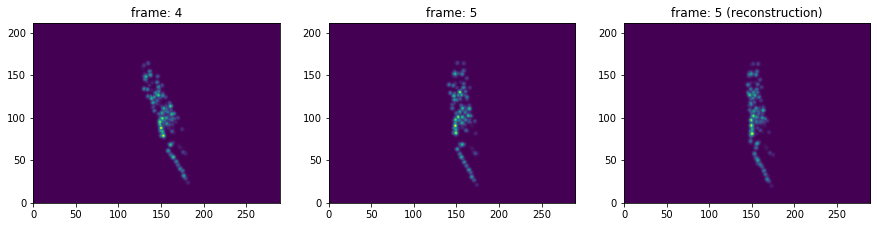

In [6]:
# Transform MP points for first image using mapping
pf_pts = model.predict(mp_1.pts)

# Reconstruct image from transformed points
mp_pf = imagerep.ImageMP(pf_pts, mp_1.wts, mp_1.cov, mp_1.img_limits)
rec_pf = imagerep.reconstruct_mp_image(mp_pf, units)

plt.figure(figsize=(15, 15))

plt.subplot(131)
plot_maxproj_units(rec_1, units)
plt.title(f'frame: {t1}')
        
plt.subplot(132)
plot_maxproj_units(rec_2, units)
plt.title(f'frame: {t2}')
        
plt.subplot(133)
plot_maxproj_units(rec_pf, units)
plt.title(f'frame: {t2} (reconstruction)');

## Changes in mapping over iterations

### Coordinates of single MP point

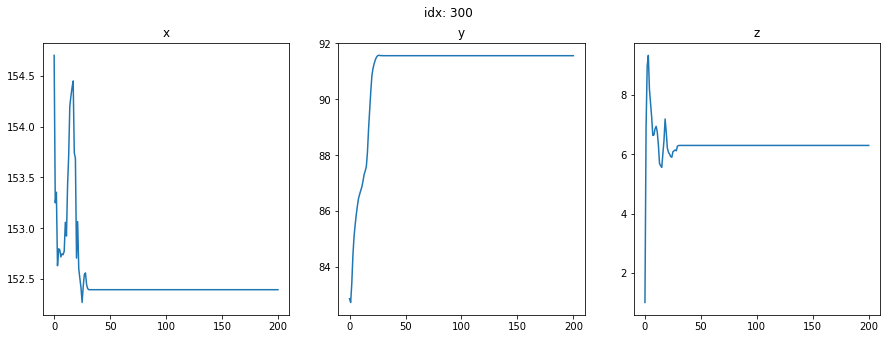

In [7]:
idx = 300

x_vals = [p[idx, 0] for p in debug['pf_pts']]
y_vals = [p[idx, 1] for p in debug['pf_pts']]
z_vals = [p[idx, 2] for p in debug['pf_pts']]

plt.figure(figsize=(15, 5))
plt.suptitle(f'idx: {idx}')

plt.subplot(131)
plt.plot(x_vals)
plt.title('x')

plt.subplot(132)
plt.plot(y_vals)
plt.title('y')

plt.subplot(133)
plt.plot(z_vals);
plt.title('z');

### MP reconstruction of entire image

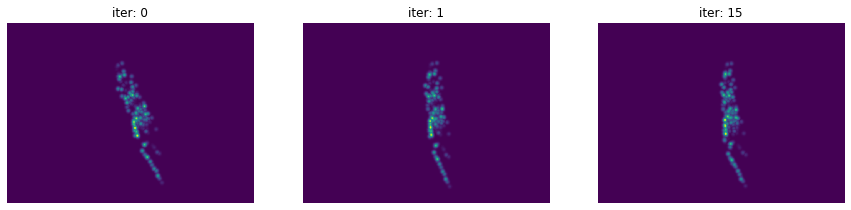

In [9]:
iters = [0, 1, 15]

trans_mps = [imagerep.ImageMP(debug['pf_pts'][i], mp_1.wts, mp_1.cov, mp_1.img_limits) for i in iters]
trans_rec = [imagerep.reconstruct_mp_image(mp, units) for mp in trans_mps]

plt.figure(figsize=(15, 15))

plt.subplot(131)
plot_maxproj_units(trans_rec[0], units)
plt.title(f'iter: {iters[0]}')
plt.axis('off')
        
plt.subplot(132)
plot_maxproj_units(trans_rec[1], units)
plt.title(f'iter: {iters[1]}')
plt.axis('off')
        
plt.subplot(133)
plot_maxproj_units(trans_rec[2], units)
plt.title(f'iter: {iters[2]}')
plt.axis('off');